In [1]:
# # if used pip install package
# !pip install xgboost
# !pip install lightgbm
# !pip install wget
# !pip install gensim
# !pip install catboost
# !pip install cython

In [42]:
import os
import sys
import logging
import gc
import wget
import time
import tarfile
import zipfile
import functools
import random
import copy
import pickle
from tqdm import tqdm_notebook, tqdm
from itertools import product, combinations
from scipy.special import comb, perm

import scipy
import numpy as np
import pandas as pd
import catboost as cbt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

import gensim
import xgboost as xgb
import lightgbm as lgb

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# import ray
# ray.init(object_store_memory=int(100e6))
# import modin.pandas as pd
# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

In [4]:
class Logger(object):
    def __init__(self, filename='default.log', stream=sys.stdout):
        self.terminal = stream
        self.log = open(filename, 'a')
        
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        
    def flush(self):
        pass

In [5]:
# sys.stdout = Logger("logs/default.log", sys.stdout)
# sys.stderr = Logger("logs/default_err.log", sys.stderr)

In [6]:
DDIR = "data"
UDDIR = "user_data"
UFEDIR = "user_data/feat_data_v05"
UMDIR = "user_data/model_data"
RESDIR = "prediction_result"

In [7]:
UID = "user_id"

# Load data (Only once)

In [8]:
# train_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/train_preliminary.zip", out=DDIR)
# test_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/test.zip", out=DDIR)

In [9]:
# def myunzip(filename):
#     zFile = zipfile.ZipFile(filename, "r")
#     for fileM in zFile.namelist(): 
#         zFile.extract(fileM, DDIR)
#         print(fileM)
#     zFile.close()

In [10]:
# myunzip(train_fname)
# myunzip(test_fname)

# Utils

In [11]:
def bch_rencol(values, prefix="", suffix=""):
    return list(map(lambda x: f"{prefix}"+"_".join(list(map(lambda y: str(y), x)))+f"{suffix}" 
                    if hasattr(x, "__iter__") and not isinstance(x, str) 
                    else f"{prefix}"+str(x)+f"{suffix}", values))

In [12]:
def mynunique(values):
    return values.nunique(dropna=False)
def getidxmax(x):
    return x.idxmax()[1]
# for time series
def at_len(x):
    return len(x)

def at_sum(x):
    return np.sum(x)

def at_max(x):
    return np.max(x)

def at_min(x):
    return np.min(x)

def at_mean(x):
    return np.mean(x)

def at_range(x):
    return at_max(x) - at_min(x)

def at_nunq(x):
    return len(set(x))

def at_lenDrange(x):
    return at_len(x)/(at_range(x)+1)

def at_lenDnunq(x):
    return at_len(x)/at_nunq(x)

def at_percentile(n):
    def at_percentile_(x):
        return np.percentile(x, n)
    at_percentile_.__name__ = f"at_percentile_{n}"
    return at_percentile_

In [13]:
OP_SET = ["sum", "max", "min", "mean", "std"]
OP_SET1 = ["nunique", "sum", "max", "min", "mean", "std", "median", "skew", at_percentile(0.25), at_percentile(0.75)]
OP_SET2 = ["sum", "max", "min", "mean", "std", "median", "skew", at_percentile(0.25), at_percentile(0.75)]

In [14]:
nesting_level = 0
is_start = None
class Timer:
    def __init__(self):
        self.start = time.time()
        self.history = [self.start]

    def check(self, info):
        current = time.time()
        print(f"[{info}] spend {current - self.history[-1]:0.2f} sec")
        self.history.append(current)

def log(entry):
    global nesting_level
    space = "-" * (4 * nesting_level)
    print(f"{space}{entry}")

def timeit(method, start_log=None):
    @functools.wraps(method)
    def timed(*args, **kw):
        global is_start
        global nesting_level

        if not is_start:
            print()

        is_start = True
        log(f"Start [{method.__name__}]:" + (start_log if start_log else ""))
        log(f'Start time: {time.strftime("%Y-%m-%d %H:%M:%S")}')
        nesting_level += 1

        start_time = time.time()
        result = method(*args, **kw)
        end_time = time.time()

        nesting_level -= 1
        log(f"End   [{method.__name__}]. Time elapsed: {end_time - start_time:0.2f} sec.")
        is_start = False

        return result

    return timed

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Data Exploration (todo)

In [16]:
# read train data
train_click_log = pd.read_csv(f"{DDIR}/train_preliminary/click_log.csv")
train_ad = pd.read_csv(f"{DDIR}/train_preliminary/ad.csv")
# tag
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [17]:
# read test data
test_click_log = pd.read_csv(f"{DDIR}/test/click_log.csv")
test_ad = pd.read_csv(f"{DDIR}/test/ad.csv")
# pd.DataFrame(np.sort(test_click_log[UID].unique()), columns=[UID]).to_csv(f"{DDIR}/test/user.csv", index=False)
test_user = pd.read_csv(f"{DDIR}/test/user.csv")

In [18]:
train_click_log.shape

(30082771, 4)

In [19]:
train_ad.shape

(2481135, 6)

In [20]:
train_user.shape

(900000, 3)

In [21]:
test_click_log.shape

(33585512, 4)

In [22]:
test_ad.shape

(2618159, 6)

In [23]:
train_ad["product_id"] = train_ad["product_id"].replace("\\N", -1).astype(int)
train_ad["industry"] = train_ad["industry"].replace("\\N", -1).astype(int)

In [24]:
test_ad["product_id"] = test_ad["product_id"].replace("\\N", -1).astype(int)
test_ad["industry"] = test_ad["industry"].replace("\\N", -1).astype(int)

In [25]:
# creative id in train (creative id is unique in train_ad)
len(train_ad)

2481135

In [26]:
# creative id in test (creative id is unique in test_ad)
len(test_ad)

2618159

In [27]:
# check whether the same creative_id in train and test have same ad info
insect1d = np.intersect1d(train_click_log.creative_id.unique(), test_click_log.creative_id.unique())
print("Same creative id: ", insect1d.shape)
print("Diff number: ", np.sum(train_ad[train_ad.creative_id.isin(insect1d)].values != test_ad[test_ad.creative_id.isin(insect1d)].values))
# checked: they all have same ad info (result is 0)

Same creative id:  (1686522,)
Diff number:  0


In [28]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(train_click_log.creative_id.unique(), train_ad.creative_id))
print("Diff list: ", np.setdiff1d(train_ad.creative_id, train_click_log.creative_id.unique()))

Diff list:  []
Diff list:  []


In [29]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(test_click_log.creative_id.unique(), test_ad.creative_id))
print("Diff list: ", np.setdiff1d(test_ad.creative_id, test_click_log.creative_id.unique()))

Diff list:  []
Diff list:  []


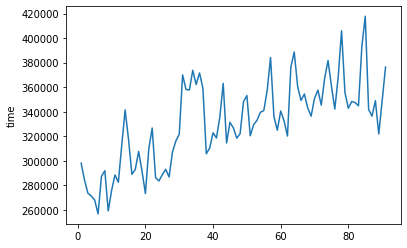

In [30]:
# click time
sns.lineplot(x=train_click_log.time.value_counts().index, y=train_click_log.time.value_counts())

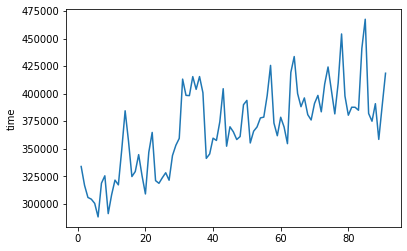

In [31]:
sns.lineplot(x=test_click_log.time.value_counts().index, y=test_click_log.time.value_counts())

In [32]:
# data_grouped = data.groupby(data.index)
# results = Parallel(n_jobs=8)(delayed(key_func)(group) for name, group in data_grouped)
# data = pd.concat(results)

# Feature engineering

## Get ID sequence (Only once)

In [33]:
# # sort by time, for time series
# train_click_log.sort_values(by="time", inplace=True)
# test_click_log.sort_values(by="time", inplace=True)

In [34]:
# tol_train = pd.merge(train_click_log, train_ad, how="left", on="creative_id")
# tol_test = pd.merge(test_click_log, test_ad, how="left", on="creative_id")

In [35]:
# del train_click_log, test_click_log
# gc.collect()

In [36]:
# @timeit
# def gen_id_series(data, dtyp="train"):
#     for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
#         tmp = data.groupby([UID], sort=False)[[col]].agg(lambda x: [f"word_{y}" for y in x])
#         tmp.columns = bch_rencol(tmp.columns)
#         tmp.to_pickle(f"{UDDIR}/imd/{dtyp}_{col}_seq.pkl")
#         tmp = None

In [37]:
# gen_id_series(tol_train, "train")

In [38]:
# gen_id_series(tol_test, "test")

In [39]:
# seqidx_dic = dict()

In [40]:
# for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
#     train_seq = pd.read_pickle(f"{UDDIR}/imd/train_{col}_seq.pkl")
#     test_seq = pd.read_pickle(f"{UDDIR}/imd/test_{col}_seq.pkl")
#     tol_seq = pd.concat([train_seq, test_seq])
#     seqidx_dic[col] = tol_seq.index

In [41]:
# with open(f"{UDDIR}/imd/seqidx_dic.pkl", "wb") as f:
#     pickle.dump(pickle.dumps(seqidx_dic), f)

## TF-IDF&Count

In [49]:
@timeit
def gen_tfidf(col, nr_max=1):
    train_seq = pd.read_pickle(f"{UDDIR}/imd/train_{col}_seq.pkl")
    test_seq = pd.read_pickle(f"{UDDIR}/imd/test_{col}_seq.pkl")
    tol_seq = pd.concat([train_seq, test_seq])
    tol_seq[col] = tol_seq[col].apply(lambda x: " ".join(x))
    
    train_seq = None
    test_seq = None
    tfidf_enc = TfidfVectorizer(ngram_range=(1, nr_max))
    tfidf_vec = tfidf_enc.fit_transform(tol_seq[col].values)
    log(f"TF-IDF shape: {tfidf_vec.shape}")

    # save sparse matrix
    scipy.sparse.save_npz(f"{UDDIR}/imd/sparse_tfidf_{col}.npz", tfidf_vec)

In [52]:
@timeit
def gen_count(col, nr_max=1):
    train_seq = pd.read_pickle(f"{UDDIR}/imd/train_{col}_seq.pkl")
    test_seq = pd.read_pickle(f"{UDDIR}/imd/test_{col}_seq.pkl")
    tol_seq = pd.concat([train_seq, test_seq])
    tol_seq[col] = tol_seq[col].apply(lambda x: " ".join(x))
    
    train_seq = None
    test_seq = None
    count_enc = CountVectorizer(ngram_range=(1, nr_max))
    count_vec = count_enc.fit_transform(tol_seq[col].values)
    log(f"Count shape: {count_vec.shape}")

    # save sparse matrix
    scipy.sparse.save_npz(f"{UDDIR}/imd/sparse_count_{col}.npz", count_vec)

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_tfidf(col)

In [53]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_count(col)


Start [gen_count]:
Start time: 2020-05-25 17:36:42
----Count shape: (1900000, 3412772)
End   [gen_count]. Time elapsed: 105.21 sec.

Start [gen_count]:
Start time: 2020-05-25 17:38:28
----Count shape: (1900000, 3027360)
End   [gen_count]. Time elapsed: 102.08 sec.

Start [gen_count]:
Start time: 2020-05-25 17:40:10
----Count shape: (1900000, 39057)
End   [gen_count]. Time elapsed: 60.50 sec.

Start [gen_count]:
Start time: 2020-05-25 17:41:10
----Count shape: (1900000, 18)
End   [gen_count]. Time elapsed: 43.09 sec.

Start [gen_count]:
Start time: 2020-05-25 17:41:53
----Count shape: (1900000, 57870)
End   [gen_count]. Time elapsed: 76.05 sec.

Start [gen_count]:
Start time: 2020-05-25 17:43:09
----Count shape: (1900000, 332)
End   [gen_count]. Time elapsed: 57.07 sec.


### SVD

In [ ]:
@timeit
def gen_svd(col, index, prefix="tfidf", n_cpt=64):
    tfidf_vec = scipy.sparse.load_npz(f"{UDDIR}/imd/sparse_{col}.npz")
    if tfidf_vec.shape[1] > n_cpt:
        svd_enc = TruncatedSVD(n_components=n_cpt, n_iter=20, random_state=2020)
        mode_svd = svd_enc.fit_transform(tfidf_vec)
    else:
        n_cpt = tfidf_vec.shape[1]
        mode_svd = tfidf_vec.todense()
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = [f"{prefix}_svd_{col}_{i}" for i in range(n_cpt)]
    mode_svd.index = index
    # save svd pkl
    mode_svd.to_pickle(f"{UFEDIR}/{prefix}_svd_{col}.pkl")

In [46]:
with open(f"{UDDIR}/imd/seqidx_dic.pkl", "rb") as f:
    seqidx_dic = pickle.loads(pickle.load(f))

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_svd(col, seqidx_dic[col])

### Stacking

## Word2Vec

In [ ]:
@timeit
def gen_w2v(col, vesize=200, win=20):
    train_seq = pd.read_pickle(f"{UDDIR}/imd/train_{col}_seq.pkl")
    test_seq = pd.read_pickle(f"{UDDIR}/imd/test_{col}_seq.pkl")
    tol_seq = pd.concat([train_seq, test_seq])
    
    train_seq = None
    test_seq = None
    if os.path.exists(f"{UMDIR}/vectors/w2v_{col}.model"):
        model = gensim.models.Word2Vec.load(f"{UMDIR}/vectors/w2v_{col}.model")
    else:
        model = gensim.models.Word2Vec(sentences=tol_seq[col], size=vesize, window=win, workers=32, sg=0, iter=10)
        model.save(f"{UMDIR}/vectors/w2v_{col}.model")
    
    w2v_list = list()
    
    for it in tqdm(tol_seq[col]):
        tmp = np.zeros(vesize)
        cnt = 0
        for wd in it:
            cnt += 1
            if wd in model:
                tmp += model[wd]
        w2v_list.append(list(tmp/cnt))
    
    w2v_avg = pd.DataFrame(w2v_list)
    w2v_avg.index = tol_seq.index
    w2v_avg.columns = [f"w2v_avg_{col}_{i}" for i in range(vesize)]
    w2v_avg.to_pickle(f"{UFEDIR}/w2v_avg_{col}.pkl")

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_w2v(col)

## Doc2Vec

In [ ]:
@timeit
def gen_d2v(col, vesize=200, win=20):
    train_seq = pd.read_pickle(f"{UDDIR}/imd/train_{col}_seq.pkl")
    test_seq = pd.read_pickle(f"{UDDIR}/imd/test_{col}_seq.pkl")
    tol_seq = pd.concat([train_seq, test_seq])
    
    train_seq = None
    test_seq = None
    
    if os.path.exists(f"{UMDIR}/vectors/d2v_{col}.model"):
        model = gensim.models.Doc2Vec.load(f"{UMDIR}/vectors/d2v_{col}.model")
    else:
        docs = [gensim.models.doc2vec.TaggedDocument(words=i[1],tags=[str(i[0])]) for i in tol_seq[col].reset_index().values]
        model = gensim.models.Doc2Vec(documents=docs, size=vesize, window=win, workers=32, iter=10)
        model.save(f"{UMDIR}/vectors/d2v_{col}.model")
    
    d2v_list = list()
    for it, cps in tqdm(tol_seq[col].reset_index().values):
#         if it in model.docvecs:
        d2v_list.append(model.docvecs[str(it)])
#         else:
#             d2v_list.append(model.infer_vector(cps))

    d2v_avg = pd.DataFrame(d2v_list)
    d2v_avg.index = tol_seq.index
    d2v_avg.columns = [f"d2v_avg_{col}_{i}" for i in range(vesize)]
    d2v_avg = reduce_mem_usage(d2v_avg)
    d2v_avg.to_pickle(f"{UFEDIR}/d2v_avg_{col}.pkl")

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_d2v(col)

## Stats features

In [ ]:
tol_train = pd.merge(train_click_log, train_ad, how="left", on="creative_id")
tol_test = pd.merge(test_click_log, test_ad, how="left", on="creative_id")

In [ ]:
del train_click_log, train_ad
del test_click_log, test_ad

### Category map to Label (use GroupFold) - a little overfitting

In [ ]:
@timeit
def gen_catemlb(train_data, test_data, tag, col):
    train_use = pd.merge(train_data[[UID, col]], tag, how="left", on=UID)
    test_use = test_data[[UID, col]]
    
    nfolds = 5
    kfold = GroupKFold(n_splits=nfolds)
    
    kf_map_df = pd.DataFrame()

    re_train_use = pd.DataFrame()
    re_test_use = pd.DataFrame()

    for tr_idx, val_idx in kfold.split(train_use, groups=train_use[UID]):
        tr_ucid, val_ucid = train_use.iloc[tr_idx], train_use.iloc[val_idx]
        kf_map = tr_ucid.groupby([col])[["age", "gender"]].agg(["mean"])
        kf_map.columns = bch_rencol(kf_map.columns, prefix=f"{col}_")
        # only use intersect between train and test
        kf_map.drop(np.setdiff1d(kf_map.index.unique(), test_use[col].unique()), inplace=True)
        # get kf_cum
        if kf_map_df.empty:
            kf_map_df = kf_map
        else:
            kf_map_df = (kf_map_df + kf_map).fillna(0)
        
        val_ucid = pd.merge(val_ucid, kf_map, how="left", on=col)
        re_train_use = pd.concat([re_train_use, val_ucid])
    
    kf_map_df = kf_map_df/nfolds
    re_test_use = pd.merge(test_use, kf_map_df, how="left", on=col)

    assert len(train_use) == len(re_train_use)
    assert len(test_use) == len(re_test_use)

    train_use = None
    test_use = None

    tmp = re_train_use.groupby([UID], sort=False)[f"{col}_age_mean", f"{col}_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/train_stats_catemlb_{col}.pkl")
    tmp = None

    tmp = re_test_use.groupby([UID], sort=False)[f"{col}_age_mean", f"{col}_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/test_stats_catemlb_{col}.pkl")
    tmp = None
    

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    gen_catemlb(tol_train, tol_test, train_user, col)

### One key(O1)-Time cost

In [ ]:
# for train
tmp = tol_train.groupby([UID], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": OP_SET1,
        "time": OP_SET1,
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
)

tmp.columns = bch_rencol(tmp.columns)

tmp.to_pickle(f"{UFEDIR}/train_stats_o1.pkl")
tmp = None

In [ ]:
# for test
tmp = tol_test.groupby([UID], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": OP_SET1,
        "time": OP_SET1,
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
)

tmp.columns = bch_rencol(tmp.columns)

tmp.to_pickle(f"{UFEDIR}/test_stats_o1.pkl")
tmp = None

In [ ]:
gc.collect()

### Comb Key(O2)-Time cost

In [ ]:
id_list = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
# train
for i in tqdm(range(1, 7)):
    for cl in combinations(id_list, i):
        key_set = [UID] + list(cl)
        tmp = tol_train.groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"{'C'.join(key_set[1:-1])}_")
        tmp.to_pickle(f"{UFEDIR}/train_stats_o2_{'C'.join(key_set)}.pkl")
        tmp = None

In [ ]:
# test
for i in tqdm(range(1, 7)):
    for cl in combinations(id_list, i):
        key_set = [UID] + list(cl)
        tmp = tol_test.groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"{'C'.join(key_set[1:-1])}_")
        tmp.to_pickle(f"{UFEDIR}/test_stats_o2_{'C'.join(key_set)}.pkl")
        tmp = None

In [ ]:
gc.collect()

### Time Windows-Time cost

In [ ]:
tm_tw = Timer()

#### Time Bins

In [ ]:
bins_set = [3, 7, 10, 30]

for bins in bins_set:
    tol_bins = pd.cut(pd.concat([tol_train["time"], tol_test["time"]]), bins, labels=range(bins))
    tol_train[f"bins{bins}"] = tol_bins[:len(tol_train)]
    tol_test[f"bins{bins}"] = tol_bins[len(tol_train):]

In [ ]:
tm_tw.check("Init Bin Set")

##### One Key(O1)

In [ ]:
# For train
for bins in bins_set:
    for cb in tqdm(range(bins)):
        tmp = tol_train[tol_train[f"bins{bins}"] == cb].groupby([UID], sort=False).agg(
            {
                UID: ["count"], 
                "click_times": OP_SET1,
                "time": OP_SET1,
                "creative_id": ["nunique"],
                "ad_id": ["nunique"],
                "product_id": ["nunique"],
                "product_category": ["nunique"],
                "advertiser_id": ["nunique"],
                "industry": ["nunique"],
            }
        )
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{cb}_")
        tmp.to_pickle(f"{UFEDIR}/train_stats_o1_bins{bins}_{cb}.pkl")
        tmp = None

In [ ]:
tm_tw.check("Generate o1 for train")

In [ ]:
# For test
for bins in bins_set:
    for cb in tqdm(range(bins)):
        tmp = tol_test[tol_test[f"bins{bins}"] == cb].groupby([UID], sort=False).agg(
            {
                UID: ["count"], 
                "click_times": OP_SET1,
                "time": OP_SET1,
                "creative_id": ["nunique"],
                "ad_id": ["nunique"],
                "product_id": ["nunique"],
                "product_category": ["nunique"],
                "advertiser_id": ["nunique"],
                "industry": ["nunique"],
            }
        )
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{cb}_")
        tmp.to_pickle(f"{UFEDIR}/test_stats_o1_bins{bins}_{cb}.pkl")
        tmp = None

In [ ]:
tm_tw.check("Generate o1 for test")

In [ ]:
gc.collect()

##### Comb Key(O2)

In [ ]:
id_list = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
# train
for bins in bins_set:
    for cb in tqdm(range(bins)):
        for i in tqdm(range(1, 7)):
            for cl in combinations(id_list, i):
                key_set = [UID] + list(cl)
                tmp = tol_train[tol_train[f"bins{bins}"] == cb].groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
                tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{cb}_{'C'.join(key_set[1:-1])}_")
                tmp.to_pickle(f"{UFEDIR}/train_stats_o2_bins{bins}_{cb}_{'C'.join(key_set)}.pkl")
                tmp = None

In [ ]:
tm_tw.check("Generate o2 bin for train")

In [ ]:
# test
for bins in bins_set:
    for cb in tqdm(range(bins)):
        for i in tqdm(range(1, 7)):
            for cl in combinations(id_list, i):
                key_set = [UID] + list(cl)
                tmp = tol_test[tol_test[f"bins{bins}"] == cb].groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
                tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{cb}_{'C'.join(key_set[1:-1])}_")
                tmp.to_pickle(f"{UFEDIR}/test_stats_o2_bins{bins}_{cb}_{'C'.join(key_set)}.pkl")
                tmp = None

In [ ]:
tm_tw.check("Generate o2 bin for test")

#### Time Slides

In [ ]:
slide_set = [1, 2, 3, 7, 14, 21, 30, 60, 90]

tol_train["max_time"] = tol_train.groupby([UID], sort=False)["time"].transform("max")
tol_test["max_time"] = tol_test.groupby([UID], sort=False)["time"].transform("max")

In [ ]:
tm_tw.check("Get Max time")

##### One Key(O1)

In [ ]:
# For train
for win in slide_set:
    tmp = tol_train[tol_train["time"] >= tol_train["max_time"] - win].groupby([UID], sort=False).agg(
        {
            UID: ["count"], 
            "click_times": OP_SET1,
            "time": OP_SET1,
            "creative_id": ["nunique"],
            "ad_id": ["nunique"],
            "product_id": ["nunique"],
            "product_category": ["nunique"],
            "advertiser_id": ["nunique"],
            "industry": ["nunique"],
        }
    )
    tmp.columns = bch_rencol(tmp.columns, prefix=f"slide{win}_")
    tmp.to_pickle(f"{UFEDIR}/train_stats_o1_slide{win}.pkl")
    tmp = None

In [ ]:
tm_tw.check("Generate o1 slide for train")

In [ ]:
# For test
for win in slide_set:
    tmp = tol_test[tol_test["time"] >= tol_test["max_time"] - win].groupby([UID], sort=False).agg(
        {
            UID: ["count"], 
            "click_times": OP_SET1,
            "time": OP_SET1,
            "creative_id": ["nunique"],
            "ad_id": ["nunique"],
            "product_id": ["nunique"],
            "product_category": ["nunique"],
            "advertiser_id": ["nunique"],
            "industry": ["nunique"],
        }
    )
    tmp.columns = bch_rencol(tmp.columns, prefix=f"slide{win}_")
    tmp.to_pickle(f"{UFEDIR}/test_stats_o1_slide{win}.pkl")
    tmp = None

In [ ]:
tm_tw.check("Generate o1 slide for test")

##### Comb Key(O2)

In [ ]:
id_list = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
# train
for win in slide_set:
    for i in tqdm(range(1, 7)):
        for cl in combinations(id_list, i):
            key_set = [UID] + list(cl)
            tmp = tol_train[tol_train["time"] >= tol_train["max_time"] - win].groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
            tmp.columns = bch_rencol(tmp.columns, prefix=f"slide{win}_{'C'.join(key_set[1:-1])}_")
            tmp.to_pickle(f"{UFEDIR}/train_stats_o2_slide{win}_{'C'.join(key_set)}.pkl")
            tmp = None

In [ ]:
tm_tw.check("Generate o2 slide for train")

In [ ]:
# test
for win in slide_set:
    for i in tqdm(range(1, 7)):
        for cl in combinations(id_list, i):
            key_set = [UID] + list(cl)
            tmp = tol_test[tol_test["time"] >= tol_test["max_time"] - win].groupby(key_set, sort=False)[key_set[-1:]].agg(["count"]).groupby([UID]).agg(OP_SET2)
            tmp.columns = bch_rencol(tmp.columns, prefix=f"slide{win}_{'C'.join(key_set[1:-1])}_")
            tmp.to_pickle(f"{UFEDIR}/test_stats_o2_slide{win}_{'C'.join(key_set)}.pkl")
            tmp = None

In [ ]:
tm_tw.check("Generate o2 slide for test")

In [ ]:
gc.collect()

### (TOP Category) One-Hot

In [ ]:
tol_data = pd.concat([tol_train, tol_test])

In [ ]:
dum_dic = {
    "creative_id": 300,
    "ad_id": 300,
    "product_id": 100,
    "advertiser_id": 100,
}

In [ ]:
for cid in dum_dic:
    use_id = tol_data[cid].value_counts().head(dum_dic[cid]).index.values
    tol_data[f"{cid}_dummy"] = tol_data[cid]
    tol_data[f"{cid}_dummy"][~tol_data[f"{cid}_dummy"].isin(use_id)] = -999

In [ ]:
for cid in  ["time", "click_times", "creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    ocid = cid
    if cid in dum_dic:
        cid = f"{cid}_dummy"
    tmp = tol_data[[UID, cid]].groupby([UID, cid], sort=False)[[cid]].agg(["count"]).unstack().fillna(0)
    tmp.columns = bch_rencol(tmp.columns)
    reduce_mem_usage(tmp).to_pickle(f"{UFEDIR}/onehot_catecnt_{ocid}.pkl")
    tmp = None

In [ ]:
gc.collect()

## Meta Train 

__weak learner prediction as features__

In [ ]:
#================Once=================#

In [ ]:
tol_test.index = -tol_test.index -1

In [ ]:
tol_data = pd.concat([tol_train, tol_test])

In [ ]:
del tol_train, tol_test
gc.collect()

In [ ]:
tol_data[f"{UID}_count"] = tol_data[[UID]].groupby([UID])[UID].transform("count")

In [ ]:
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    tmp = tol_data[[UID, col]]
    tol_data[f"{UID}_{col}_std"] = tmp.groupby([UID])[col].transform("std")
    tol_data[f"{col}_{UID}_count"] = tmp.groupby([col])[UID].transform("count")
    tol_data[f"{col}_{UID}_std"] = tmp.groupby([col])[UID].transform("std")
    tmp = None

In [ ]:
for col in ["time", "click_times"]:
    tmp = tol_data[[UID, col]]
    tol_data[f"{UID}_{col}_std"] = tmp.groupby([UID])[col].transform("std")
    tol_data[f"{UID}_{col}_mean"] = tmp.groupby([UID])[col].transform("mean")
    tmp = None

In [ ]:
tol_data = reduce_mem_usage(tol_data)

In [ ]:
tol_data.to_pickle(f"{UDDIR}/imd/tol_data.pkl")

In [ ]:
#==============End===============#

In [ ]:
## if have tol_data.pkl
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")
test_user = pd.read_csv(f"{DDIR}/test/user.csv")

tol_data = pd.read_pickle(f"{UDDIR}/imd/tol_data.pkl")

In [ ]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))** .5

In [ ]:
gc.collect()

### For age

In [ ]:
tol_data = pd.merge(tol_data, train_user[[UID, "age"]], how="left", on=UID)

In [ ]:
# use df_hist_train df_new_train df_hist_new_train to train 3 models
train_df = tol_data[tol_data["age"].notnull()]
test_df = tol_data[tol_data["age"].isnull()]

In [ ]:
drop_features = [UID, "age"]
cat_features = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
feats = [f for f in tol_data.columns if f not in drop_features]

In [ ]:
n_splits= 3
folds = GroupKFold(n_splits=n_splits)
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
print ('feats:' + str(len(feats)))

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["age"],groups=train_df[UID])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df["age"].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["age"].iloc[valid_idx] 
    
    print("Train Index:",train_idx,",Val Index:",valid_idx)

    params = {
               "objective" : "regression", 
               "boosting" : "gbdt", 
               "metric" : "rmse",  
               "max_depth": 7, 
               "num_leaves" : 31, 
               "max_bin" : 255, 
               "learning_rate" : 0.1, 
               "subsample" : 0.8,
               "colsample_bytree" : 0.8, 
               "verbosity": -1,
               "num_threads" : -1,
    }
    

    if n_fold >= 0:
        evals_result = {}
        dtrain = lgb.Dataset(
            train_x, label=train_y,categorical_feature=cat_features)
        dval = lgb.Dataset(
            valid_x, label=valid_y, reference=dtrain,categorical_feature=cat_features)
        bst = lgb.train(
            params, dtrain, num_boost_round=30000,
            valid_sets=[dval], early_stopping_rounds=100, verbose_eval=20,)#feval = evalerror
        
        new_list = sorted(zip(feats, bst.feature_importance('gain')),key=lambda x: x[1], reverse=True)[:]
        for item in new_list:
            print (item) 

        oof_preds[valid_idx] = bst.predict(valid_x, num_iteration=bst.best_iteration)

        sub_preds += bst.predict(test_df[feats], num_iteration=bst.best_iteration) / folds.n_splits # test_df_new

In [ ]:
cv = rmse(train_df["age"],  oof_preds)
print('Full OOF RMSE %.6f' % cv)  

In [ ]:
a = train_df[[UID]]
b = test_df[[UID]]

a["age_pred"] = oof_preds
b["age_pred"] = sub_preds

a1 = a.groupby([UID])["age_pred"].agg(["mean", "std", "min", "max", "median", "skew"])
b1 = b.groupby([UID])["age_pred"].agg(["mean", "std", "min", "max", "median", "skew"])

In [ ]:
a1.append(b1).add_prefix("age_gkf_agg_pred_").reset_index().sort_values(by=[UID]).reset_index(drop=True).to_pickle(f"{UFEDIR}/meta_age_group_regeress.pkl")

### For gender

In [ ]:
tol_data = pd.merge(tol_data, train_user[[UID, "gender"]], how="left", on=UID)

In [ ]:
# use df_hist_train df_new_train df_hist_new_train to train 3 models
train_df = tol_data[tol_data["gender"].notnull()]
test_df = tol_data[tol_data["gender"].isnull()]

In [ ]:
drop_features = [UID, "gender"]
cat_features = ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]

In [ ]:
feats = [f for f in tol_data.columns if f not in drop_features]

In [ ]:
n_splits= 3
folds = GroupKFold(n_splits=n_splits)
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
print ('feats:' + str(len(feats)))

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["gender"],groups=train_df[UID])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df["gender"].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["gender"].iloc[valid_idx] 
    
    print("Train Index:",train_idx,",Val Index:",valid_idx)

    params = {
               "objective" : "regression", 
               "boosting" : "gbdt", 
               "metric" : "rmse",  
               "max_depth": 7, 
               "num_leaves" : 31, 
               "max_bin" : 255, 
               "learning_rate" : 0.1, 
               "subsample" : 0.8,
               "colsample_bytree" : 0.8, 
               "verbosity": -1,
               "num_threads" : -1,
    }
    

    if n_fold >= 0:
        evals_result = {}
        dtrain = lgb.Dataset(
            train_x, label=train_y,categorical_feature=cat_features)
        dval = lgb.Dataset(
            valid_x, label=valid_y, reference=dtrain,categorical_feature=cat_features)
        bst = lgb.train(
            params, dtrain, num_boost_round=30000,
            valid_sets=[dval], early_stopping_rounds=100, verbose_eval=20,)#feval = evalerror
        
        new_list = sorted(zip(feats, bst.feature_importance('gain')),key=lambda x: x[1], reverse=True)[:]
        for item in new_list:
            print (item) 

        oof_preds[valid_idx] = bst.predict(valid_x, num_iteration=bst.best_iteration)

        sub_preds += bst.predict(test_df[feats], num_iteration=bst.best_iteration) / folds.n_splits # test_df_new

In [ ]:
cv = rmse(train_df["gender"],  oof_preds)
print('Full OOF RMSE %.6f' % cv)

In [ ]:
a = train_df[[UID]]
b = test_df[[UID]]

a["gender_pred"] = oof_preds
b["gender_pred"] = sub_preds

a1 = a.groupby([UID])["gender_pred"].agg(["mean", "std", "min", "max", "median", "skew"])
b1 = b.groupby([UID])["gender_pred"].agg(["mean", "std", "min", "max", "median", "skew"])

In [ ]:
a1.append(b1).add_prefix("gender_gkf_agg_pred_").reset_index().sort_values(by=[UID]).reset_index(drop=True).to_pickle(f"{UFEDIR}/meta_gender_group_regeress.pkl")

## Concat

In [ ]:
feat_fname = sorted(os.listdir(UFEDIR))

In [ ]:
# # reduce memory (only once)
# for fname in feat_fname:
#     if fname.startswith("w2v_") or fname.startswith("tfidf_svd_") or fname.startswith("meta_age_") or fname.startswith("meta_gender_") or (fname.find("catemlb") != -1) or (fname.find("stats") != -1):
#         print("current filename: ", fname)
#         reduce_mem_usage(pd.read_pickle(f"{UFEDIR}/{fname}")).to_pickle(f"{UFEDIR}/{fname}")

In [ ]:
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")
test_user = pd.read_csv(f"{DDIR}/test/user.csv")

In [ ]:
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_feat[UID] = train_user[UID]
test_feat[UID] = test_user[UID]

In [ ]:
for fname in feat_fname:
    if fname.startswith("w2v_"):
        print("current filename: ", fname)
        cur_w2v = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, cur_w2v, how="left", on=UID)
        test_feat = pd.merge(test_feat, cur_w2v, how="left", on=UID)
        cur_w2v = None

In [ ]:
# # not use
# for fname in feat_fname:
#     if fname.startswith("train_stats_"):
#         print("current filename: ", fname)
#         train_feat = pd.merge(train_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)
#     elif fname.startswith("test_stats_"):
#         print("current filename: ", fname)
#         test_feat = pd.merge(test_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)

In [ ]:
for fname in feat_fname:
    if fname.startswith("tfidf_svd_"):
        print("current filename: ", fname)
        cur_tfidf_svd = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, cur_tfidf_svd, how="left", on=UID)
        test_feat = pd.merge(test_feat, cur_tfidf_svd, how="left", on=UID)
        cur_tfidf_svd = None

In [ ]:
for fname in feat_fname:
    if fname.startswith("meta_age_"):
        print("current filename: ", fname)
        age_agg_pred = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, age_agg_pred, how="left", on=UID)
        test_feat = pd.merge(test_feat, age_agg_pred, how="left", on=UID)
        age_agg_pred = None

In [ ]:
for fname in feat_fname:
    if fname.startswith("meta_gender_"):
        print("current filename: ", fname)
        gender_agg_pred = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, gender_agg_pred, how="left", on=UID)
        test_feat = pd.merge(test_feat, gender_agg_pred, how="left", on=UID)
        gender_agg_pred = None

In [ ]:
for fname in feat_fname:
    if fname.startswith("d2v_"):
        print("current filename: ", fname)
        cur_d2v = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, cur_d2v, how="left", on=UID)
        test_feat = pd.merge(test_feat, cur_d2v, how="left", on=UID)
        cur_d2v = None

In [ ]:
for fname in feat_fname:
    if fname.startswith("onehot_catecnt_"):
        print("current filename: ", fname)
        cur_ohcc = pd.read_pickle(f"{UFEDIR}/{fname}")
        train_feat = pd.merge(train_feat, cur_ohcc, how="left", on=UID)
        test_feat = pd.merge(test_feat, cur_ohcc, how="left", on=UID)

In [ ]:
# to make sure feat and user(target) have same order
# if true --> sum == 0
np.sum(train_feat[UID] != train_user[UID])

In [ ]:
# to make sure feat and user(target) have same order
# if true --> sum == 0
np.sum(test_feat[UID] != test_user[UID])

In [ ]:
# to make sure train and test features have same order
# if true --> sum == 0
np.sum(train_feat.columns != test_feat.columns)

In [ ]:
train_feat.shape

In [ ]:
test_feat.shape

In [ ]:
train_feat.memory_usage().sum() / 1024**2 

In [ ]:
test_feat.memory_usage().sum() / 1024**2 

In [ ]:
gc.collect()

In [ ]:
# train_feat.to_pickle(f"{UDDIR}/feat_ing/train_feat_tol_v05.pkl")
# test_feat.to_pickle(f"{UDDIR}/feat_ing/test_feat_tol_v05.pkl")

In [ ]:
# train_feat = pd.read_pickle(f"{UDDIR}/feat_ing/train_feat_tol_v05.pkl")
# test_feat = pd.read_pickle(f"{UDDIR}/feat_ing/test_feat_tol_v05.pkl")
# train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [ ]:
# train_feat.drop([col for col in train_feat.columns if col.find("creative_id_gender_") != -1], axis=1, inplace=True)

In [ ]:
# test_feat.drop([col for col in test_feat.columns if col.find("creative_id_gender_") != -1], axis=1, inplace=True)

In [ ]:
# list(train_feat.columns)

# Training&Prediction

In [ ]:
train_feat.drop(UID, axis=1, inplace=True)
test_feat.drop(UID, axis=1, inplace=True)

In [ ]:
prob_suffix = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))

## LightGBM

### For Offline both Age and Gender

In [ ]:
# split data
train_feat_tr, train_feat_val, train_tag_tr, train_tag_val = train_test_split(train_feat, train_user, test_size=0.2, random_state=2020)

In [ ]:
train_feat_tr.drop(UID, axis=1, inplace=True)

In [ ]:
train_feat_val.drop(UID, axis=1, inplace=True)

In [ ]:
gc.collect()

### For Age

#### Offline

In [ ]:
lgbds_train_tr_age = lgb.Dataset(train_feat_tr, train_tag_tr["age"]-1)
lgbds_train_val_age = lgb.Dataset(train_feat_val, train_tag_val["age"]-1)

In [ ]:
params_age = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 10,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,     
    
}

In [ ]:
model_lgb_multi_age_off = lgb.train(params_age, lgbds_train_tr_age, num_boost_round=1000, valid_sets=[lgbds_train_val_age], verbose_eval=50, early_stopping_rounds=100)

In [ ]:
train_val_age_prob = model_lgb_multi_age_off.predict(train_feat_val, num_iteration=model_lgb_multi_age_off.best_iteration)
train_val_age_pred = [list(x).index(max(x))+1 for x in train_val_age_prob]
age_acy = accuracy_score(train_val_age_pred, train_tag_val["age"])

#### Online

In [ ]:
lgbds_train_age = lgb.Dataset(train_feat, train_user["age"]-1)

In [ ]:
params_age = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 10,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,     
    
}

In [ ]:
model_lgb_multi_age = lgb.train(params_age, lgbds_train_age, num_boost_round=1000, verbose_eval=50)

In [ ]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_age.save_model(f"{UMDIR}/lgb_multi_age_{ndt}.model")

#### KFold

In [ ]:
tm_mage = Timer()

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

In [ ]:
params_age = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 10,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    
}

In [ ]:
scores = []
result_proba = []
age_feat_import_df = pd.DataFrame

In [ ]:
for cur_fold, (tr_idx, val_idx) in enumerate(kfold.split(train_feat, train_user["age"]-1)):
    tr_x = tr_y = val_x = val_y = None
    tr_x, tr_y, val_x, val_y = train_feat.iloc[tr_idx], train_user["age"].iloc[tr_idx]-1, train_feat.iloc[val_idx], train_user["age"].iloc[val_idx]-1
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    lgb_model = lgb.train(params_age, train_set,
                          valid_sets=[val_set], early_stopping_rounds=100, num_boost_round=40000, verbose_eval=50)
    # to save memory
    del train_set, val_set, tr_x
    
    # save feature importance
    tmp = pd.DataFrame(lgb_model.feature_name(), columns=["feature_name"])
    tmp[f"feature_importance_fold{cur_fold}"] = lgb_model.feature_importance()
    if age_feat_import_df.empty:
        age_feat_import_df = tmp
    else:
        age_feat_import_df = pd.merge(age_feat_import_df, tmp, how="left", on="feature_name")
        
    # get valid pred
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)
    val_score = accuracy_score(val_pred, val_y)
    # get test pred
    result_proba.append(lgb_model.predict(
        test_feat, num_iteration=lgb_model.best_iteration))
    scores.append(val_score)
    print("current validation score: ", val_score)
    
    gc.collect()
print("accuracy score: ", np.mean(scores))

In [ ]:
predicted_age = np.argmax(np.mean(result_proba, axis=0), axis=1) + 1

In [ ]:
np.save(f"{RESDIR}/ageprob-{prob_suffix}.csv", result_proba)
age_feat_import_df.to_csv(f"{UMDIR}/gender_feat_importance_{prob_suffix}.model", index=False)

In [ ]:
tm_mage.check("K-Fold train costs")

In [ ]:
Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_logloss: 1.58469	valid_0's multi_error: 0.633817
[100]	valid_0's multi_logloss: 1.51445	valid_0's multi_error: 0.615078
[150]	valid_0's multi_logloss: 1.4817	valid_0's multi_error: 0.605533
[200]	valid_0's multi_logloss: 1.4614	valid_0's multi_error: 0.599544
[250]	valid_0's multi_logloss: 1.44759	valid_0's multi_error: 0.595261
[300]	valid_0's multi_logloss: 1.43745	valid_0's multi_error: 0.591328
[350]	valid_0's multi_logloss: 1.42973	valid_0's multi_error: 0.588456
[400]	valid_0's multi_logloss: 1.42384	valid_0's multi_error: 0.586428
[450]	valid_0's multi_logloss: 1.41923	valid_0's multi_error: 0.584689
[500]	valid_0's multi_logloss: 1.41543	valid_0's multi_error: 0.583739
[550]	valid_0's multi_logloss: 1.41241	valid_0's multi_error: 0.583194
[600]	valid_0's multi_logloss: 1.40995	valid_0's multi_error: 0.582956
[650]	valid_0's multi_logloss: 1.40784	valid_0's multi_error: 0.581533
[700]	valid_0's multi_logloss: 1.40617	valid_0's multi_error: 0.58145
[750]	valid_0's multi_logloss: 1.40487	valid_0's multi_error: 0.5809
[800]	valid_0's multi_logloss: 1.40368	valid_0's multi_error: 0.5806
[850]	valid_0's multi_logloss: 1.40279	valid_0's multi_error: 0.580439
[900]	valid_0's multi_logloss: 1.40206	valid_0's multi_error: 0.579944
[950]	valid_0's multi_logloss: 1.40149	valid_0's multi_error: 0.579756
[1000]	valid_0's multi_logloss: 1.40099	valid_0's multi_error: 0.579489
[1050]	valid_0's multi_logloss: 1.40061	valid_0's multi_error: 0.579328
[1100]	valid_0's multi_logloss: 1.40027	valid_0's multi_error: 0.579389
[1150]	valid_0's multi_logloss: 1.40015	valid_0's multi_error: 0.579344
[1200]	valid_0's multi_logloss: 1.39993	valid_0's multi_error: 0.579328
[1250]	valid_0's multi_logloss: 1.39979	valid_0's multi_error: 0.579456
[1300]	valid_0's multi_logloss: 1.39977	valid_0's multi_error: 0.579456
Early stopping, best iteration is:
[1212]	valid_0's multi_logloss: 1.39987	valid_0's multi_error: 0.578922
current validation score:  0.4210777777777778
accuracy score:  0.4182433333333333

### For Gender

#### Offline

In [ ]:
lgbds_train_tr_gender = lgb.Dataset(train_feat_tr, train_tag_tr["gender"]-1)
lgbds_train_val_gender = lgb.Dataset(train_feat_val, train_tag_val["gender"]-1)

In [ ]:
params_gender = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 2,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
}

In [ ]:
model_lgb_multi_gender_off = lgb.train(params_gender, lgbds_train_tr_gender, num_boost_round=1000, valid_sets=[lgbds_train_val_gender], verbose_eval=50, early_stopping_rounds=100)

In [ ]:
train_val_gender_prob = model_lgb_multi_gender_off.predict(train_feat_val, num_iteration=model_lgb_multi_gender_off.best_iteration)
train_val_gender_pred = [list(x).index(max(x))+1 for x in train_val_gender_prob]
gender_acy = accuracy_score(train_val_gender_pred, train_tag_val["gender"])

#### Online

In [ ]:
lgbds_train_gender = lgb.Dataset(train_feat, train_user["gender"]-1)

In [ ]:
params_gender = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 2,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
}

In [ ]:
model_lgb_multi_gender = lgb.train(params_gender, lgbds_train_gender, num_boost_round=1000, verbose_eval=50)

In [ ]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_gender.save_model(f"{UMDIR}/lgb_multi_gender_{ndt}.model")

#### KFold

In [ ]:
tm_mgender = Timer()

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

In [ ]:
params_gender = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 2,
    "metric": ["multi_logloss", "multi_error"],
    "learning_rate": 0.1,
    "seed": 2020,
    "n_jobs": -1,
    "min_child_weight": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
}

In [ ]:
gender_scores = []
gender_result_proba = []
gender_feat_import_df = pd.DataFrame()

In [ ]:
for cur_fold, (tr_idx, val_idx) in enumerate(kfold.split(train_feat, train_user["gender"]-1)):
    tr_x = tr_y = val_x = val_y = None
    tr_x, tr_y, val_x, val_y = train_feat.iloc[tr_idx], train_user["gender"].iloc[tr_idx]-1, train_feat.iloc[val_idx], train_user["gender"].iloc[val_idx]-1
    train_set = lgb.Dataset(tr_x, tr_y)
    val_set = lgb.Dataset(val_x, val_y)
    lgb_model = lgb.train(params_gender, train_set,
                          valid_sets=[val_set], early_stopping_rounds=100, num_boost_round=40000, verbose_eval=50)
    
    # to save memory
    del train_set, val_set, tr_x
    
    # save feature importance
    tmp = pd.DataFrame(lgb_model.feature_name(), columns=["feature_name"])
    tmp[f"feature_importance_fold{cur_fold}"] = lgb_model.feature_importance()
    if gender_feat_import_df.empty:
        gender_feat_import_df = tmp
    else:
        gender_feat_import_df = pd.merge(gender_feat_import_df, tmp, how="left", on="feature_name")
    # get valid pred
    val_pred = np.argmax(lgb_model.predict(
        val_x, num_iteration=lgb_model.best_iteration), axis=1)
    val_score = accuracy_score(val_pred, val_y)
    # get test pred
    gender_result_proba.append(lgb_model.predict(
        test_feat, num_iteration=lgb_model.best_iteration))
    gender_scores.append(val_score)
    log(f"current validation score: {val_score}")
    gc.collect()
log(f"accuracy score: {np.mean(gender_scores)}")

In [ ]:
predicted_gender = np.argmax(np.mean(gender_result_proba, axis=0), axis=1) + 1

In [ ]:
np.save(f"{RESDIR}/genderprob-{prob_suffix}.csv", gender_result_proba)

In [ ]:
gender_feat_import_df.to_csv(f"{UMDIR}/gender_feat_importance_{prob_suffix}.model")

In [ ]:
tm_mgender.check("K-Fold train costs")

In [ ]:
Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_logloss: 0.207812	valid_0's multi_error: 0.0769833
[100]	valid_0's multi_logloss: 0.192275	valid_0's multi_error: 0.0714111
[150]	valid_0's multi_logloss: 0.186464	valid_0's multi_error: 0.0687278
[200]	valid_0's multi_logloss: 0.183157	valid_0's multi_error: 0.0670389
[250]	valid_0's multi_logloss: 0.181112	valid_0's multi_error: 0.0661056
[300]	valid_0's multi_logloss: 0.179827	valid_0's multi_error: 0.0654333
[350]	valid_0's multi_logloss: 0.178971	valid_0's multi_error: 0.0650667
[400]	valid_0's multi_logloss: 0.178272	valid_0's multi_error: 0.0645833
[450]	valid_0's multi_logloss: 0.177909	valid_0's multi_error: 0.0645389
[500]	valid_0's multi_logloss: 0.177659	valid_0's multi_error: 0.0643389
[550]	valid_0's multi_logloss: 0.177448	valid_0's multi_error: 0.0643333
[600]	valid_0's multi_logloss: 0.177394	valid_0's multi_error: 0.0641778
[650]	valid_0's multi_logloss: 0.177319	valid_0's multi_error: 0.0641667
[700]	valid_0's multi_logloss: 0.17723	valid_0's multi_error: 0.0640278
[750]	valid_0's multi_logloss: 0.177158	valid_0's multi_error: 0.0642
[800]	valid_0's multi_logloss: 0.177063	valid_0's multi_error: 0.0641056
Early stopping, best iteration is:
[707]	valid_0's multi_logloss: 0.177211	valid_0's multi_error: 0.0640111
current validation score: 0.9359888888888889

In [ ]:
np.mean(np.array(gender_scores) + np.array(scores))

## NN (TODO)

In [ ]:
attention - transformer

In [ ]:
LSTM -

In [ ]:
uid, seq
1, [0, 1, 3, 4, 5]
2, [2, 3, 8]

# Generate Prediction Result

In [ ]:
# model_lgb_multi_age = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_age_20200511045531.model")

In [ ]:
# model_lgb_multi_gender = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_gender_20200511034408.model")

In [ ]:
res = test_user[[UID]]

In [ ]:
res["predicted_age"] = predicted_age
# res["predicted_age"] = [list(x).index(max(x))+1 for x in model_lgb_multi_age.predict(test_feat, num_iteration=model_lgb_multi_age.best_iteration)]

In [ ]:
res["predicted_gender"] = predicted_gender
# res["predicted_gender"] = [list(x).index(max(x))+1 for x in model_lgb_multi_gender.predict(test_feat, num_iteration=model_lgb_multi_gender.best_iteration)]

In [ ]:
res_suffix = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
res.to_csv(f"{RESDIR}/res-{res_suffix}.csv", index=False)

In [ ]:
res["predicted_age"].value_counts()

In [ ]:
res["predicted_gender"].value_counts()

In [ ]:
res.shape

In [ ]:
tmp = pd.read_csv(f"{RESDIR}/res-20200518082609.csv")

In [ ]:
tmp["predicted_age"].value_counts()

In [ ]:
tmp["predicted_gender"].value_counts()

In [ ]:
res["predicted_age"] = tmp["predicted_age"]

In [ ]:
train_user.gender.value_counts()

In [ ]:
train_user.age.value_counts()

In [ ]:
gc.collect()

# Cent result to COS

In [ ]:
from ti import session
ti_session = session.Session()

In [ ]:
inputs = ti_session.upload_data(path=f"{RESDIR}/res-20200515004850.csv", bucket="etveritas-1252104022", key_prefix=RESDIR)